# Introduction
We are now ready to get to work. The following Notebook is all about preliminary data exploration. Starting with our improved *Metadata_Extended.csv*, we seek to answer some basic questions about the dataset we were given and pave the way for our qiime pipeline.
Some questions we want to answer with this Notebook are:

- did the two sequencing techniques generate different number of mags per sample?
- are all samples sequenced by both techniques?
- what is the genome size distribution of our datasets?

other interesting questions are:  
- nation of origin distribution of samples?
- what foods types are sampled in what proportion?





## Setup

In [19]:
#set up environment
import os
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization
%matplotlib inline
import matplotlib.pyplot as plt

# create directories for the notebook. DO NOT change
raw_data = 'data/raw'
metadata_dir = 'data/processed/metadata'

# fetches useful files for the current notebook. All files will be saved in $data_dir
#!wget 'https://polybox.ethz.ch/index.php/s/nMa2WaWEDft3kMr/download' -O data/Download.zip
#!unzip -o data/Download.zip -d data
#!rm data/Download.zip

In [20]:
%%bash -s "$raw_data" "$metadata_dir"
mkdir -p "$1"
mkdir -p "$2"

## importing Metadata_Expanded

In [21]:
metadata = pd.read_csv(f'{metadata_dir}/Metadata_Extended.tsv', sep='\t')
metadata.head(3) # Let's take a quick peek

,sample-id,mag-id,sample,samp_country,category,fermented_food_type
0,PB_B039_Aa_Gp_La,4fed5b68-163a-4b85-b3bf-3b6ada10905b,B039_Aa_Gp_La,Benin,fermented fish,Lanhouin
1,PB_B039_Aa_Gp_La,0c88dca7-0e2b-411d-879f-e636df0334ab,B039_Aa_Gp_La,Benin,fermented fish,Lanhouin
2,PB_B039_Aa_Gp_La,04a43b31-0c19-47e3-8559-77c5009ca765,B039_Aa_Gp_La,Benin,fermented fish,Lanhouin


# Exploration
## Question 1: Mags per sample compared
It is important to compare sequencing techniques retrieved MAGs on a per-sample basis as they may represent differences in read depth and quality, which is one of the questions we aim to answer for our project. Visualizing how the MAGs are distributed is also useful to acknowledje possible batch effect due to the different sample size down the line.

In [22]:
# Group metadata by sample and sample-id, optaining a frequency per sample per technique
counts = metadata.groupby(['sample', 'sample-id']).size()
counts.head(5)

sample  sample-id
36fe4   PB_36fe4       8
3ee22   PB_3ee22       4
9b8b5   PB_9b8b5       6
A001    IL_A001       29
        PB_A001      112
dtype: int64

In [23]:
# IL subset
IL = counts[counts['sample-id'].str.startswith('IL_')]

# PB subset
PB = counts[counts['sample-id'].str.startswith('PB_')]


A barplot showing the frequencies of both techniques per sample is a good way to visualize our dataset

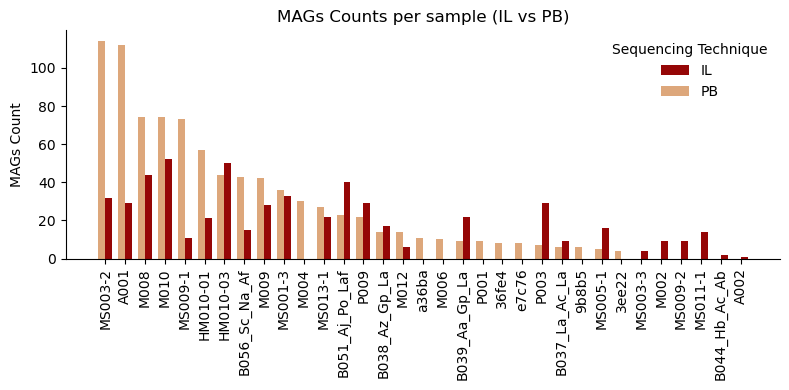

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Merge IL and PB counts
merged = IL[['sample', 'count']].rename(columns={'count':'IL_count'}).merge(
    PB[['sample', 'count']].rename(columns={'count':'PB_count'}),
    on='sample', how='outer'
).fillna(0)

# Sort by PB_count descending
merged = merged.sort_values('PB_count', ascending=False)

samples = merged['sample']
x = np.arange(len(samples))
width = 0.35

fig, ax = plt.subplots(figsize=(8,4))
ax.bar(x + width/2, merged['IL_count'], width, label='IL', color = '#950606')
ax.bar(x - width/2, merged['PB_count'], width, label='PB', color = '#DDA77B')

# hide borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticks(x)
ax.set_xticklabels(samples, rotation=90)
ax.set_ylabel('MAGs Count')
ax.set_title('MAGs Counts per sample (IL vs PB)')
ax.legend(title='Sequencing Technique', frameon=False)


plt.tight_layout()
plt.show()


In [25]:
g = metadata.groupby(['sample', 'sample-id']).size().reset_index(name='n')

counts_per_sample = g.groupby('sample')['sample-id'].nunique()

single = counts_per_sample[counts_per_sample == 1].index
multi  = counts_per_sample[counts_per_sample > 1].index


In [12]:
merged_df['samp_country'].unique()

array(['Thailand', 'Switzerland', 'Benin', 'Slovenia', 'Germany', 'Laos'],
      dtype=object)

In [13]:
merged_df.groupby('samp_country').size()

samp_country
Benin           400
Germany          20
Laos           1136
Slovenia         38
Switzerland      16
Thailand       1242
dtype: int64

Our samples were sampled in 6 different countries: Benin, Germany, Laos, Slovenia, Switzerland, and Thailand. Most samples come from Thailand and Laos (621 and 568, respectively), while the least number of samples were taken in Switzerland.

**Note: the commented out code has a long output since it calculates for all files, so we only give averages for all files of the following calculations:**

#### Calculating GC content:

In [14]:
'''def calculate_gc_content(sequence):
    g = sequence.count('G')
    c = sequence.count('C')
    gc_content = (g + c) / len(sequence) * 100 if len(sequence) > 0 else 0
    return gc_content


def analyze_gc_content(fasta_file):
    gc_contents = []
    with open(fasta_file, 'r') as file:
        sequence = ""
        for line in file:
            line = line.strip()
            if line.startswith(">"):  # Header line (ignore it)
                if sequence:  # If there was a previous sequence, process it
                    gc_contents.append(calculate_gc_content(sequence))
                sequence = ""  # Reset sequence for the next record
            else:
                sequence += line  # Append sequence data
        if sequence:
            gc_contents.append(calculate_gc_content(sequence))
    return gc_contents

# Function that walk through directories and process FASTA files
def process_directory(base_directory):
    gc_results = {}

    for root, dirs, files in os.walk(base_directory):
        for file in files:
            if file.endswith(".fasta") or file.endswith(".fa"):
                fasta_file_path = os.path.join(root, file)
                gc_contents = analyze_gc_content(fasta_file_path)
                # Save results -> file path as the key and GC contents as the value
                gc_results[fasta_file_path] = gc_contents

    return gc_results


illumina_folder = 'data/Illumina_MAGs'
pacbio_folder = 'data/PacBio_MAGs'


illumina_gc = process_directory(illumina_folder)
pacbio_gc = process_directory(pacbio_folder)


print("Illumina GC Content:")
for file, gc in illumina_gc.items():
    print(f"{file}: Average GC content = {sum(gc)/len(gc):.2f}%")

print("\nPacBio GC Content:")
for file, gc in pacbio_gc.items():
    print(f"{file}: Average GC content = {sum(gc)/len(gc):.2f}%")'''


'def calculate_gc_content(sequence):\n    g = sequence.count(\'G\')\n    c = sequence.count(\'C\')\n    gc_content = (g + c) / len(sequence) * 100 if len(sequence) > 0 else 0\n    return gc_content\n\n\ndef analyze_gc_content(fasta_file):\n    gc_contents = []\n    with open(fasta_file, \'r\') as file:\n        sequence = ""\n        for line in file:\n            line = line.strip()\n            if line.startswith(">"):  # Header line (ignore it)\n                if sequence:  # If there was a previous sequence, process it\n                    gc_contents.append(calculate_gc_content(sequence))\n                sequence = ""  # Reset sequence for the next record\n            else:\n                sequence += line  # Append sequence data\n        if sequence:\n            gc_contents.append(calculate_gc_content(sequence))\n    return gc_contents\n\n# Function that walk through directories and process FASTA files\ndef process_directory(base_directory):\n    gc_results = {}\n\n    for ro

In [15]:
import Bio
from Bio import SeqIO
import numpy as np

def calculate_gc_content(sequence):
    g = sequence.count('G')
    c = sequence.count('C')
    gc_content = (g + c) / len(sequence) * 100 if len(sequence) > 0 else 0
    return gc_content

def analyze_gc_content(fasta_file):
    gc_contents = []
    with open(fasta_file, 'r') as file:
        sequence = ""
        for line in file:
            line = line.strip()
            if line.startswith(">"):  # Header line (ignore it)
                if sequence:  # If there was a previous sequence, process it
                    gc_contents.append(calculate_gc_content(sequence))
                sequence = ""  # Reset sequence for the next record
            else:
                sequence += line  # Append sequence data
        if sequence: 
            gc_contents.append(calculate_gc_content(sequence))
    return gc_contents

# Function that walk through directories and process FASTA files
def process_directory(base_directory):
    all_gc_contents = []  # List to store all GC content values across all files
    for root, dirs, files in os.walk(base_directory):
        for file in files:
            if file.endswith(".fasta") or file.endswith(".fa"):
                fasta_file_path = os.path.join(root, file)
                gc_contents = analyze_gc_content(fasta_file_path)
                all_gc_contents.extend(gc_contents)  # Add the GC content from this file to the list
    return all_gc_contents


illumina_folder = 'data/Illumina_MAGs'
pacbio_folder = 'data/PacBio_MAGs'


illumina_gc = process_directory(illumina_folder)
pacbio_gc = process_directory(pacbio_folder)


def calculate_average_gc(gc_contents):
    return sum(gc_contents) / len(gc_contents) if gc_contents else 0


print(f"Average GC content for Illumina: {calculate_average_gc(illumina_gc):.2f}%")
print(f"Average GC content for PacBio: {calculate_average_gc(pacbio_gc):.2f}%")


Average GC content for Illumina: 0.00%
Average GC content for PacBio: 0.00%


**Both technologies recovered genomes with very similar base compositions.**

#### Calculating N50 and L50

In [16]:
'''# Function to calculate N50 and L50
def calculate_n50_l50(contig_lengths):
    """Calculate the N50 and L50 of the contig lengths."""
    contig_lengths.sort(reverse=True)  # Sort contig lengths in descending order
    total_length = sum(contig_lengths)
    half_total_length = total_length / 2

    cumulative_length = 0
    n50 = 0
    l50 = 0
    for length in contig_lengths:
        cumulative_length += length
        l50 += 1
        if cumulative_length >= half_total_length and n50 == 0:
            n50 = length
    
    return n50, l50

# Function to get the lengths of sequences from a FASTA file
def get_contig_lengths(fasta_file):
    """Reads a FASTA file and returns a list of contig lengths."""
    contig_lengths = []
    with open(fasta_file, 'r') as file:
        sequence = ""
        for line in file:
            line = line.strip()
            if line.startswith(">"):  # Header line (ignore it)
                if sequence:  # If there was a previous sequence, process it
                    contig_lengths.append(len(sequence))
                sequence = ""  # Reset sequence for the next record
            else:
                sequence += line  # Appends sequence data
        if sequence:  # Process the last sequence
            contig_lengths.append(len(sequence))
    return contig_lengths

# Function that walk through directories and process FASTA files
def process_directory(base_directory):
    n50_results = {}

    for root, dirs, files in os.walk(base_directory):
        for file in files:
            if file.endswith(".fasta") or file.endswith(".fa"):
                fasta_file_path = os.path.join(root, file)
                
                # Get contig lengths from the file
                contig_lengths = get_contig_lengths(fasta_file_path)
                
                # If there are valid contigs, calculates N50 and L50
                if contig_lengths:
                    n50, l50 = calculate_n50_l50(contig_lengths)
                    n50_results[fasta_file_path] = (n50, l50)

    return n50_results

illumina_folder = 'data/Illumina_MAGs'
pacbio_folder = 'data/PacBio_MAGs'

# Process the directories and calculate N50 and L50
illumina_n50 = process_directory(illumina_folder)
pacbio_n50 = process_directory(pacbio_folder)

print("Illumina N50 and L50:")
for file, (n50, l50) in illumina_n50.items():
    print(f"{file}: N50 = {n50}, L50 = {l50}")

print("\nPacBio N50 and L50:")
for file, (n50, l50) in pacbio_n50.items():
    print(f"{file}: N50 = {n50}, L50 = {l50}")'''

'# Function to calculate N50 and L50\ndef calculate_n50_l50(contig_lengths):\n    """Calculate the N50 and L50 of the contig lengths."""\n    contig_lengths.sort(reverse=True)  # Sort contig lengths in descending order\n    total_length = sum(contig_lengths)\n    half_total_length = total_length / 2\n\n    cumulative_length = 0\n    n50 = 0\n    l50 = 0\n    for length in contig_lengths:\n        cumulative_length += length\n        l50 += 1\n        if cumulative_length >= half_total_length and n50 == 0:\n            n50 = length\n    \n    return n50, l50\n\n# Function to get the lengths of sequences from a FASTA file\ndef get_contig_lengths(fasta_file):\n    """Reads a FASTA file and returns a list of contig lengths."""\n    contig_lengths = []\n    with open(fasta_file, \'r\') as file:\n        sequence = ""\n        for line in file:\n            line = line.strip()\n            if line.startswith(">"):  # Header line (ignore it)\n                if sequence:  # If there was a pre

In [17]:
# Function to calculate N50 and L50
def calculate_n50_l50(contig_lengths):
    """Calculate the N50 and L50 of the contig lengths."""
    contig_lengths.sort(reverse=True)  # Sort contig lengths in descending order
    total_length = sum(contig_lengths)
    half_total_length = total_length / 2

    cumulative_length = 0
    n50 = 0
    l50 = 0
    for length in contig_lengths:
        cumulative_length += length
        l50 += 1
        if cumulative_length >= half_total_length and n50 == 0:
            n50 = length
    
    return n50, l50

# Function to get the lengths of sequences from a FASTA file
def get_contig_lengths(fasta_file):
    """Reads a FASTA file and returns a list of contig lengths."""
    contig_lengths = []
    with open(fasta_file, 'r') as file:
        sequence = ""
        for line in file:
            line = line.strip()
            if line.startswith(">"):  # Header line (ignore it)
                if sequence:  # If there was a previous sequence, process it
                    contig_lengths.append(len(sequence))
                sequence = ""  # Reset sequence for the next record
            else:
                sequence += line  # Append sequence data
        if sequence:  # Process the last sequence
            contig_lengths.append(len(sequence))
    return contig_lengths

# Function that walk through directories and process FASTA files
def process_directory(base_directory):
    all_contig_lengths = []

    for root, dirs, files in os.walk(base_directory):
        for file in files:
            if file.endswith(".fasta") or file.endswith(".fa"):
                fasta_file_path = os.path.join(root, file)
                
                # Getting contig lengths from the file
                contig_lengths = get_contig_lengths(fasta_file_path)
                
                # Adding contig lengths to the overall list
                if contig_lengths:
                    all_contig_lengths.extend(contig_lengths)

    return all_contig_lengths

illumina_folder = 'data/Illumina_MAGs'
pacbio_folder = 'data/PacBio_MAGs'

# Processing the directories and getting all contig lengths
illumina_contig_lengths = process_directory(illumina_folder)
pacbio_contig_lengths = process_directory(pacbio_folder)

# Calculating N50 and L50 for Illumina
if illumina_contig_lengths:
    illumina_n50, illumina_l50 = calculate_n50_l50(illumina_contig_lengths)
else:
    illumina_n50, illumina_l50 = 0, 0

# Calculating N50 and L50 for PacBio
if pacbio_contig_lengths:
    pacbio_n50, pacbio_l50 = calculate_n50_l50(pacbio_contig_lengths)
else:
    pacbio_n50, pacbio_l50 = 0, 0


print(f"Illumina N50: {illumina_n50}")
print(f"Illumina L50: {illumina_l50}")

print(f"PacBio N50: {pacbio_n50}")
print(f"PacBio L50: {pacbio_l50}")


Illumina N50: 0
Illumina L50: 0
PacBio N50: 0
PacBio L50: 0


**PacBio assemblies are more contiguous, with a 15-fold higher N50 and a 13-fold lower L50 compared to Illumina assemblies.**

# Genome Size

In [18]:
#set up environment
import pandas as pd
import qiime2 as q2
import seaborn as sns
import matplotlib.pyplot as plt
import os


import numpy as np
from pathlib import Path
import gzip, io
from qiime2 import Visualization

In [19]:
#### fetch files from polybox
! wget -O $data_dir/polybox_files.zip "https://polybox.ethz.ch/index.php/s/56JaAiKdGwioBKN/download"

# unzip polybox files
! unzip -o $data_dir/polybox_files.zip -d $data_dir
! rm $data_dir/polybox_files.zip

#untar MAGs files and store everything in data_dir
!tar -xzf $data_dir/applied_bioinformatics/Illumina_MAGs.tar.gz -C $data_dir
!tar -xzf $data_dir/applied_bioinformatics/PacBio_MAGs.tar.gz -C $data_dir
!mv $data_dir/applied_bioinformatics/merged_metadata_filtered.tsv $data_dir
!rm -r $data_dir/applied_bioinformatics

--2025-12-02 23:44:12--  https://polybox.ethz.ch/index.php/s/56JaAiKdGwioBKN/download
Resolving polybox.ethz.ch (polybox.ethz.ch)... 129.132.71.243
Connecting to polybox.ethz.ch (polybox.ethz.ch)|129.132.71.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘data/01_Data_Exploration/polybox_files.zip’

data/01_Data_Explor     [       <=>          ] 492.28M   409MB/s    in 1.2s    

2025-12-02 23:44:13 (409 MB/s) - ‘data/01_Data_Exploration/polybox_files.zip’ saved [516188455]

Archive:  data/01_Data_Exploration/polybox_files.zip
   creating: data/01_Data_Exploration/applied_bioinformatics/
 extracting: data/01_Data_Exploration/applied_bioinformatics/.DS_Store  
 extracting: data/01_Data_Exploration/applied_bioinformatics/Illumina_MAGs.tar.gz  
 extracting: data/01_Data_Exploration/applied_bioinformatics/PacBio_MAGs.tar.gz  
 extracting: data/01_Data_Exploration/applied_bioinformatics/merged_metadata_filtered.tsv  


In [20]:
# Create metadata df for exploration
from uuid import uuid4

# load metadata (sample-level metadata table, indexed by sample-id)
metadata_df = pd.read_csv(f"{data_dir}/merged_metadata_filtered.tsv", sep="\t", index_col=0)

# ---------------------------------------------------------------------
# 1) Rename all FASTA files with UUIDs
#    - This avoids collisions if different samples had identical filenames.
#    - We traverse all subdirectories under data_dir and rename *.fa / *.fasta.
# ---------------------------------------------------------------------
for technique in os.listdir(data_dir):
    tech_path = os.path.join(data_dir, technique)
    if not os.path.isdir(tech_path):
        continue
    for sample_id in os.listdir(tech_path):
        sample_path = os.path.join(tech_path, sample_id)
        if not os.path.isdir(sample_path):
            continue
        for file in os.listdir(sample_path):
            if file.endswith((".fa", ".fasta")):
                old_path = os.path.join(sample_path, file)
                # use a UUID as a new filename (still with .fa extension)
                new_path = os.path.join(sample_path, f"{uuid4()}.fa")
                os.rename(old_path, new_path)

# ---------------------------------------------------------------------
# 2) Build a manifest-like table linking sample-id, MAG ID and filename
#    - We walk the directory tree again, collect all FASTA files,
#      and only keep entries where sample_id exists in metadata_df.
# ---------------------------------------------------------------------
records = []

for technique in os.listdir(data_dir):
    tech_path = os.path.join(data_dir, technique)
    if not os.path.isdir(tech_path):
        continue
    for sample_id in os.listdir(tech_path):
        sample_path = os.path.join(tech_path, sample_id)
        if not os.path.isdir(sample_path):
            continue
        for f in os.listdir(sample_path):
            if f.endswith((".fa", ".fasta")):
                abs_path = os.path.abspath(os.path.join(sample_path, f))
                # only include sample IDs that are present in the metadata
                if sample_id in metadata_df.index:
                    mag_id = os.path.splitext(f)[0]  # filename without extension
                    records.append((sample_id, mag_id, abs_path))

# build dataframe
manifest_df = pd.DataFrame.from_records(records, columns=["sample-id", "mag-id", "filename"])

# save as MANIFEST (comma-separated, no index; QIIME2 manifest is typically CSV)
manifest_path = os.path.join(data_dir, "MANIFEST")
manifest_df.to_csv(manifest_path, sep=",", index=False)

print(f"MANIFEST saved to: {manifest_path}")
print(manifest_df.head())
print(manifest_df.columns)

# ---------------------------------------------------------------------
# 3) Genome size distribution
#    - We compute total sequence length (bp) for each MAG FASTA file,
#      build a per-MAG DataFrame, and explore genome size statistics.
# ---------------------------------------------------------------------

## Genome size distribution

# Recursively list FASTA(-like) files under a root directory.
def list_fasta_files(root):
    root = Path(root)
    exts = {".fa", ".fna", ".fasta"}
    out = []
    for p in root.rglob("*"):
        if p.is_file():
            suf = p.suffix.lower()
            # handle compressed filenames like .fa.gz
            suf2 = "".join(p.suffixes[-2:]).lower()
            if suf in exts or suf2 in {".fa.gz", ".fna.gz", ".fasta.gz"}:
                out.append(p)
    return out

# Return total sequence length in bp for a FASTA file. Supports plain and gzipped.
def fasta_total_length(path):
    total = 0
    open_fn = gzip.open if str(path).endswith(".gz") else open
    # Use text mode with utf-8 fallback and ignore problematic characters
    with open_fn(path, "rt", errors="ignore") as fh:
        for line in fh:
            if not line or line.startswith(">"):
                continue
            total += len(line.strip())
    return total

# Build DataFrame with columns: mag_id, size_bp, _tech, path.
def build_df_from_folder(folder, tech_label):
    files = list_fasta_files(folder)
    rows = []
    for f in files:
        # derive MAG ID from filename stem
        mag_id = f.stem.replace(".fa","").replace(".fna","").replace(".fasta","")
        size_bp = fasta_total_length(f)
        rows.append((mag_id, size_bp, tech_label, str(f)))
    return pd.DataFrame(rows, columns=["mag_id", "size_bp", "_tech", "path"])

# Define the input folders for Illumina and PacBio MAGs
illu_dir = Path(data_dir) / "Illumina_MAGs"
pacb_dir = Path(data_dir) / "PacBio_MAGs"

# 1) Build df_mag: concatenated genome-size table for both techniques
#    Here we label Illumina as "short" and PacBio as "long".
df_ill = build_df_from_folder(illu_dir, "short")  # Illumina = short-read
df_pac = build_df_from_folder(pacb_dir, "long")   # PacBio  = long-read
df_mag = pd.concat([df_ill, df_pac], ignore_index=True)

# also compute genome size in Mbp for convenience / metadata export
df_mag["_size_mbp"] = df_mag["size_bp"] / 1e6

# Helper to print basic statistics for each technique
def check_tech_label(df, tech_label):
    print(f"Checking {tech_label} data:")
    print(f"  Max size: {df['size_bp'].max()} bp")
    print(f"  Min size: {df['size_bp'].min()} bp")
    print(f"  Mean size: {df['size_bp'].mean()} bp")
    print(f"  Number of sequences: {len(df)}")

# Print Illumina and PacBio genome size statistics
check_tech_label(df_ill, "short")  # Illumina
check_tech_label(df_pac, "long")   # PacBio

# ---------------------------------------------------------------------
# 4) Build a QIIME 2–ready metadata TSV with genome size information
#    - This table is later visualized with `qiime metadata tabulate`.
# ---------------------------------------------------------------------
meta = df_mag.rename(columns={
    "mag_id":   "sample-id",
    "_tech":    "technique",
    "_size_mbp":"genome_size_mbp"
})[["sample-id", "technique", "genome_size_mbp", "size_bp", "path"]]

meta.to_csv(f"{data_dir}/genome_sizes_metadata.tsv", sep="\t", index=False)
print("Wrote genome_sizes_metadata.tsv")

# Turn the metadata into an interactive QIIME 2 visualization
! qiime metadata tabulate \
  --m-input-file $data_dir/genome_sizes_metadata.tsv \
  --o-visualization $data_dir/genome_sizes_table.qzv

Visualization.load(f"{data_dir}/genome_sizes_table.qzv")

# ---------------------------------------------------------------------
# 5) Visual exploration of genome size distributions (Kbp, log scale)
#    - Histogram, boxplot, and ECDF by sequencing technique.
# ---------------------------------------------------------------------

# --- Plot in Kbp ---

# 0) Convert to Kbp
df_k = df_mag.copy()
df_k["_size_kbp"] = df_k["size_bp"] / 1e3  # size in Kbp

# knobs to control plotting behavior
LOG = True               # set True to use log-scale axes
FOCUS_MAX_KBP = None     # set None for full range; 1000 Kbp = 1 Mbp

# 1) Summary statistics per technique (useful for figure captions)
summary = (
    df_k.groupby("_tech")["_size_kbp"]
        .agg(n="count", mean="mean", median="median",
             q25=lambda s: s.quantile(0.25),
             q75=lambda s: s.quantile(0.75),
             min="min", max="max")
        .round(2)
)
print(summary)

# 2) Histogram of genome sizes by technique
plt.figure(figsize=(7, 4.5))
x = df_k["_size_kbp"].to_numpy()
xmin = max(1, x[x>0].min()) if LOG else df_k["_size_kbp"].min()
xmax = df_k["_size_kbp"].max()
bins = (np.logspace(np.log10(xmin), np.log10(xmax), 35)
        if LOG else np.linspace(xmin, np.quantile(x, 0.99), 35))

for t in ["short", "long"]:
    vals = df_k.loc[df_k["_tech"] == t, "_size_kbp"].values
    plt.hist(vals, bins=bins, alpha=0.6, label=t, density=True)

if LOG:
    plt.xscale("log")
if FOCUS_MAX_KBP is not None:
    plt.xlim(0, FOCUS_MAX_KBP)
plt.xlabel("Genome size (Kbp)" + (" [log]" if LOG else ""))
plt.ylabel("Density")
plt.title("Genome size distribution by technique (Kbp)")
plt.legend()
plt.tight_layout()
plt.show()

# 3) Boxplot + jittered points by technique
plt.figure(figsize=(6, 4.5))
tech_order = ["short", "long"]
data_for_box = [df_k.loc[df_k["_tech"]==t, "_size_kbp"].values for t in tech_order]

# Adjust boxplot appearance
plt.boxplot(
    data_for_box,
    labels=tech_order,
    showfliers=False,
    widths=0.4,
    notch=False,
    patch_artist=False,  # no fill color
    boxprops=dict(linewidth=1.5, color='black'),   # bold black border
    medianprops=dict(linewidth=1.5, color='red'),  # red median line
    whiskerprops=dict(linewidth=1.5, color='black')  # bold whiskers
)

# Add jittered individual points on top of the boxplot
rng = np.random.default_rng(0)
for xi, t in enumerate(tech_order, start=1):
    vals = df_k.loc[df_k["_tech"]==t, "_size_kbp"].values
    jit = rng.normal(0, 0.04, size=len(vals))
    plt.plot(np.full_like(vals, xi) + jit, vals, "o", ms=3, alpha=0.35)

if LOG:
    plt.yscale("log")
if FOCUS_MAX_KBP is not None:
    plt.ylim(0, FOCUS_MAX_KBP)
plt.ylabel("Genome size (Kbp)" + (" [log]" if LOG else ""))
plt.title("Genome size by technique (Kbp)")
plt.tight_layout()
plt.show()

# 4) ECDF (empirical cumulative distribution function) by technique
def ecdf(x):
    x = np.sort(x)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

plt.figure(figsize=(7, 4.5))
for t in tech_order:
    x_ecdf, y_ecdf = ecdf(df_k.loc[df_k["_tech"]==t, "_size_kbp"].values)
    plt.step(x_ecdf, y_ecdf, where="post", label=t)

if LOG:
    plt.xscale("log")
if FOCUS_MAX_KBP is not None:
    plt.xlim(0, FOCUS_MAX_KBP)
plt.xlabel("Genome size (Kbp)" + (" [log]" if LOG else ""))
plt.ylabel("ECDF")
plt.title("ECDF of genome sizes by technique (Kbp)")
plt.legend()
plt.tight_layout()
plt.show()


MANIFEST saved to: data/01_Data_Exploration/MANIFEST
  sample-id                                mag-id  \
0      M004  9d47f527-5408-4d04-9020-fdfbbe31d080   
1      M004  88baf06d-d00b-4c05-a27f-2cc006906d54   
2      M004  27d504ba-3503-47ba-b067-b933eba193d0   
3      M004  c3be7c77-51ae-4452-afb6-e7829ba1c4b6   
4      M004  c21cdfa3-3621-48eb-adf4-7a116770dff6   

                                            filename  
0  /home/jovyan/REPORT/data/01_Data_Exploration/P...  
1  /home/jovyan/REPORT/data/01_Data_Exploration/P...  
2  /home/jovyan/REPORT/data/01_Data_Exploration/P...  
3  /home/jovyan/REPORT/data/01_Data_Exploration/P...  
4  /home/jovyan/REPORT/data/01_Data_Exploration/P...  
Index(['sample-id', 'mag-id', 'filename'], dtype='object')
Checking short data:
  Max size: 105229916 bp
  Min size: 200090 bp
  Mean size: 1475088.4283088236 bp
  Number of sequences: 1088
Checking long data:
  Max size: 26029257 bp
  Min size: 200069 bp
  Mean size: 961954.9648526077 bp
  Number